Challenge 4: Developing Post-Disaster Housing Response

Nur Afsa Syeda

Enviornment Setup

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '3'  # Setting number of threads to avoid memory leak warning

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
import dash
from dash import dcc, html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output, State
import webbrowser
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS.*")

In [2]:
# File paths
file_path = './data_1-FL.csv'                                  # data file
risk_path = './National_risk_index_FL.csv'
shapefile_path = './tl_rd22_12_tract/tl_rd22_12_tract.shp'   # Shapefile

# Function to read data files
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
    else:
        raise ValueError("Unsupported file format. Only CSV file is supported.")
    return df

def read_shapefile(shapefile_path):
    gdf = gpd.read_file(shapefile_path)
    return gdf

In [3]:
# Load data
data = read_dataframe(file_path)
risk_index = read_dataframe(risk_path)
shapefile_gdf = read_shapefile(shapefile_path)

In [4]:
# List of columns to keep
columns_to_keep = [
    'geoid', 'geoid_year', 'state', 'county', 'state_fips_code', 'county_fips_code',
    'air_toxics_cancer', 'diesel_pm_ej', 'lead_paint_ej', 'ozone_ej', 'pm2_5_ej',
    'superfund_prox_ej', 'traffic_prox_ej', 'haz_waste_prox_ej', 'wastewater_ej',
    'exp_build_loss_rate_pctile', 'exp_pop_loss_rate_pctile', 'energy_burden',
    'energy_burden_pctile', 'pov_pct_est', 'pov_u18_pct_est', 'pov_65plus_pct_est',
    'med_hh_inc_est', 'med_inc_black_est', 'med_inc_white_est', 'med_inc_hisp_est',
    'pop_pct_black', 'pop_pct_white', 'hlthins_pop__pct_est', 'flood_risk_30yr_share',
    'fire_risk_30yr_share', 'housecost_med_est', 'housecost_owner_est', 'housecost_rent_est',
    'lihtc_qualified_tracts', 'total_cdfi_lending', 'med_mortgage_loan', 'med_property_value',
    'med_sba_504_loan', 'med_sba_7a_loan', 'num_mortgage_loans', 'num_mortgage_denials',
    'num_mortgages_origin', 'num_sba_504_loans', 'num_sba_7a_loans'
]

# Subset the data
data = data[columns_to_keep]

In [5]:
# Rename columns for readability
data = data.rename(columns={
    'air_toxics_cancer': 'Air toxics cancer risk',
    'diesel_pm_ej': 'Diesel particulate matter ej index',
    'lead_paint_ej': 'Lead paint ej index',
    'ozone_ej': 'Ozone ej index',
    'pm2_5_ej': 'Particulate matter 2.5 ej index',
    'superfund_prox_ej': 'Superfund proximity ej index',
    'traffic_prox_ej': 'Traffic proximity ej index',
    'haz_waste_prox_ej': 'Hazardous waste proximity ej index',
    'wastewater_ej': 'Wastewater discharge ej index',
    'exp_build_loss_rate_pctile': 'Building Loss Rate Percentile',
    'exp_pop_loss_rate_pctile': 'Population Loss Rate Percentile',
    'energy_burden': 'Energy burden',
    'energy_burden_pctile': 'Energy Burden Percentile',
    'pov_pct_est': 'Below poverty percentage',
    'pov_u18_pct_est': 'Percentage of people under 18 living below poverty',
    'pov_65plus_pct_est': 'Percentage of people over 65 living below poverty',
    'med_hh_inc_est': 'Median household income',
    'med_inc_black_est': 'Median income for Black population',
    'med_inc_white_est': 'Median income for White population',
    'med_inc_hisp_est': 'Median income for Hispanic/Latino population',
    'pop_pct_black': 'Percentage of Black population',
    'pop_pct_white': 'Percentage of White population',
    'hlthins_pop__pct_est': 'Percentage of people with health insurance',
    'flood_risk_30yr_share': 'Share of properties at risk of flood in 30 years',
    'fire_risk_30yr_share': 'Share of properties at risk of fire in 30 years',
    'housecost_med_est': 'Median housing costs',
    'housecost_owner_est': 'Median housing cost for owners',
    'housecost_rent_est': 'Median housing cost for renters',
    'lihtc_qualified_tracts': 'Low-Income Housing Tax Credit (LIHTC) qualified tracts',
    'total_cdfi_lending': 'CDFI loan amount',
    'med_mortgage_loan': 'Median mortgage loan',
    'med_property_value': 'Median property value',
    'med_sba_504_loan': 'Median SBA 504 loan',
    'med_sba_7a_loan': 'Median SBA 7a loan',
    'num_mortgage_loans': 'Number of mortgage loans',
    'num_mortgage_denials': 'Number of mortgage denials',
    'num_mortgages_origin': 'Number of mortgages originated',
    'num_sba_504_loans': 'Number of SBA 504 loans',
    'num_sba_7a_loans': 'Number of SBA 7a loans'
})

In [6]:
# Subset the relevant columns from the risk data
nri_subset = risk_index[[
    'State FIPS Code', 'County FIPS Code', 'Census Tract', 'Census Tract FIPS Code',
    'Population (2020)', 'Building Value ($)', 'Agriculture Value ($)',
    'Area (sq mi)', 'National Risk Index - Score - Composite',
    'Expected Annual Loss - Total - Composite', 'Expected Annual Loss - Building Value - Composite',
    'Expected Annual Loss - Population - Composite', 'Expected Annual Loss - Agriculture Value - Composite',
    'Social Vulnerability - Score', 'Social Vulnerability - Rating',
    'Community Resilience - Score', 'Community Resilience - Rating',
    'Heat Wave - Expected Annual Loss - Total', 'Heat Wave - Expected Annual Loss Rate - National Percentile',
    'Hurricane - Expected Annual Loss - Total', 'Hurricane - Expected Annual Loss Rate - National Percentile',
    'Riverine Flooding - Expected Annual Loss - Total', 'Riverine Flooding - Expected Annual Loss Rate - National Percentile',
    'Strong Wind - Expected Annual Loss - Total', 'Strong Wind - Expected Annual Loss Rate - National Percentile',
    'Tornado - Expected Annual Loss - Total', 'Tornado - Expected Annual Loss Rate - National Percentile',
    'Coastal Flooding - Expected Annual Loss - Total', 'Coastal Flooding - Expected Annual Loss Rate - National Percentile'
]]

In [7]:
# Merge data with risk data
merged_data = pd.merge(data, nri_subset, left_on='geoid', right_on='Census Tract FIPS Code', how='left')

In [8]:
# Replace missing values and drop NaN rows
missing_values = [-666666666, -222222222]
merged_data_clean = merged_data.replace(missing_values, np.nan).dropna()

In [9]:
# Ensure working with copies
shapefile_gdf = shapefile_gdf.copy()
merged_data_clean = merged_data_clean.copy()

In [10]:
# Convert 'GEOID' and 'geoid' columns to string
shapefile_gdf['GEOID'] = shapefile_gdf['GEOID'].astype(str)
merged_data_clean['geoid'] = merged_data_clean['geoid'].astype(str)

In [11]:
# Perform the merge operation
merged_gdf = shapefile_gdf.merge(merged_data_clean, left_on='GEOID', right_on='geoid')

In [12]:
# Standardize column strings
merged_gdf = merged_gdf.apply(lambda col: col.str.strip().str.title() if col.dtype == 'object' else col)

In [13]:
# Clustering
features = ['Hurricane - Expected Annual Loss Rate - National Percentile',
            'Riverine Flooding - Expected Annual Loss Rate - National Percentile',
            'Strong Wind - Expected Annual Loss Rate - National Percentile',
            'Tornado - Expected Annual Loss Rate - National Percentile',
            'Building Loss Rate Percentile', 'Population Loss Rate Percentile', 'Energy Burden Percentile']
X = merged_gdf[features]

# Apply Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the Elbow Method
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)

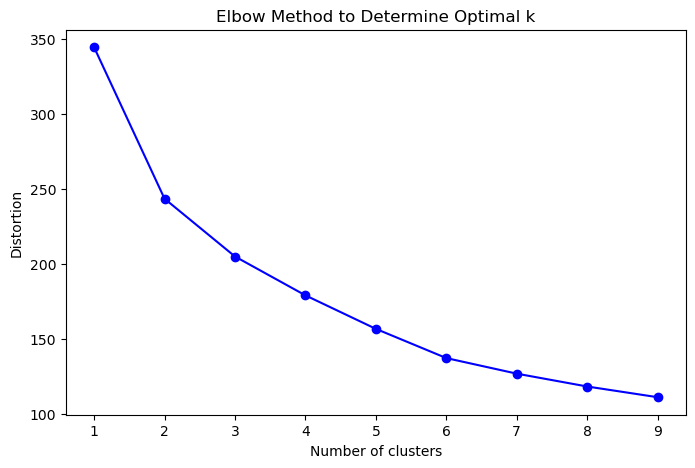

In [14]:
# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method to Determine Optimal k')
plt.show()

In [15]:
# Apply K-means clustering with the optimal number of clusters
optimal_k = 3  # Assuming optimal number is 3 after visualizing the elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
merged_gdf['Risk_Cluster'] = kmeans.fit_predict(X_scaled)

In [16]:
# Visualize clusters on the map
merged_gdf['Risk_Cluster'] = merged_gdf['Risk_Cluster']

In [17]:
# Convert GeoPandas DataFrame to GeoJSON using to_json()
geojson_data = merged_gdf.geometry.to_json()

# Function to generate the cluster map
def generate_cluster_map():
    fig = px.choropleth_mapbox(
        merged_gdf,
        geojson=merged_gdf.__geo_interface__,
        locations=merged_gdf.index,
        color='Risk_Cluster',  # Color by cluster
        hover_name="county",
        hover_data=features + ['Population (2020)'],
        color_continuous_scale="YlOrRd",
        mapbox_style="carto-positron",
        zoom=6,
        center={"lat": 27.9944024, "lon": -81.7602544},
        opacity=0.6
    )
    
    # Overlay population bubbles
    fig.add_trace(go.Scattermapbox(
        lat=merged_gdf.geometry.centroid.y,
        lon=merged_gdf.geometry.centroid.x,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=merged_gdf['Population (2020)'] / 1000,
            color='blue',
            opacity=0.7
        ),
        text=merged_gdf['county'],
        hoverinfo='text'
    ))
    
    fig.update_layout(mapbox_style="carto-positron", margin={"r": 0, "t": 0, "l": 0, "b": 0})
    return fig

In [18]:
# Function to generate risk map based on selected metric
def generate_risk_map(selected_metric):
    fig = px.choropleth_mapbox(
        merged_gdf,
        geojson=merged_gdf.__geo_interface__,
        locations=merged_gdf.index,
        color=selected_metric,  # Select the appropriate risk metric
        hover_name="county",
        color_continuous_scale="YlOrRd",
        mapbox_style="carto-positron",
        zoom=6,
        center={"lat": 27.9944024, "lon": -81.7602544},
        opacity=0.7
    )
    fig.update_layout(mapbox_style="carto-positron", margin={"r": 0, "t": 0, "l": 0, "b": 0})
    return fig

In [19]:
# Function to generate socio-economic and housing maps based on the selected metric and county
def generate_plot(metric, selected_county=None):
    filtered_gdf = merged_gdf if selected_county is None else merged_gdf[merged_gdf['county'] == selected_county]

    # Generate choropleth map for geographic-based metrics (e.g., income, poverty)
    fig = px.choropleth_mapbox(
        filtered_gdf,
        geojson=filtered_gdf.__geo_interface__,
        locations=filtered_gdf.index,
        color=metric,  # Use the selected metric for color scale
        hover_name="county",
        hover_data=[metric],
        color_continuous_scale="Viridis",
        mapbox_style="carto-positron",
        zoom=9,  # Zoom in on the selected county
        center={"lat": filtered_gdf.geometry.centroid.y.mean(), "lon": filtered_gdf.geometry.centroid.x.mean()},
        opacity=0.7
    )
    # Add a title based on the selected county
    if selected_county:
        fig.update_layout(title=f'{metric} for {selected_county}')
    fig.update_layout(mapbox_style="carto-positron", margin={"r": 0, "t": 60, "l": 20, "b": 0})
    return fig

In [20]:
# Initialize Dash app with Bootstrap styling
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.FLATLY])  # FLATLY theme for a modern look

# Custom CSS for styling improvements
app.index_string = '''
<!DOCTYPE html>
<html lang="en">
    <head>
        {%metas%}
        <title>Florida Risk & Resilience Dashboard</title>
        {%favicon%}
        {%css%}
        <style>
            .page-container {
                margin: 0 auto;
                max-width: 1600px;
                padding: 20px;
            }
            h1, h3 {
                text-align: center;
                margin-top: 10px;
                margin-bottom: 20px;
            }
            .dropdown {
                margin-bottom: 20px;
            }
            .button-group {
                display: flex;
                flex-wrap: wrap;
                justify-content: center;
                gap: 5px;
            }
            .graph-container {
                margin: 20px 0;
            }
            .card {
                margin: 10px;
                padding: 15px;
            }
        </style>
    </head>
    <body>
        <div class="page-container">
            {%app_entry%}
        </div>
        <footer>
            {%config%}
            {%scripts%}
            {%renderer%}
        </footer>
    </body>
</html>
'''

# Layout for the dashboard
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(html.H1("Florida Risk & Resilience: Insights for Vulnerable Communities"), width=12),
    ], style={'padding': '20px'}),

    # Risk Metrics Section
    dbc.Row([
        dbc.Col(html.H3("Disaster Risk Analysis"), width=12),
        dbc.Col([
            dbc.ButtonGroup([
                dbc.Button("Hurricane", id='hurricane-risk-btn', n_clicks=0, color="primary"),
                dbc.Button("Strong Wind", id='strong-wind-risk-btn', n_clicks=0, color="primary"),
                dbc.Button("Flood", id='flood-risk-btn', n_clicks=0, color="primary"),
                dbc.Button("Tornado", id='tornado-risk-btn', n_clicks=0, color="primary"),
                dbc.Button("Building", id='building-loss-btn', n_clicks=0, color="primary"),
                dbc.Button("Population", id='population-loss-btn', n_clicks=0, color="primary"),
                dbc.Button("Energy Burden", id='energy-burden-btn', n_clicks=0, color="primary"),
            ], className='button-group'),
        ], width=12, className='graph-container'),
        dbc.Col(dcc.Graph(id='risk-metric-map', style={'height': '500px'}), width=12),
    ], className="card"),

    # Cluster Map and County Dropdown Section
    dbc.Row([
        dbc.Col(html.H3("Community Risk Clusters"), width=12),
        dbc.Col(dcc.Graph(id='cluster-map', figure=generate_cluster_map(), style={'height': '500px'}), width=8),
    ], className="card"),

    # Socio-Economic Data Section
    dbc.Row([
        dbc.Col(html.H3("Community Socio-Economic Vulnerability", id='socio-header'), width=12),
        dbc.Col([
            dbc.ButtonGroup([
                dbc.Button("Poverty", id='poverty-btn', n_clicks=0),
                dbc.Button("Household Income", id='income-btn', n_clicks=0),
                dbc.Button("Income for Black Population", id='black-income-btn', n_clicks=0),
                dbc.Button("Income for White Population", id='white-income-btn', n_clicks=0),
                dbc.Button("Income for Hispanic/Latino Population", id='hispanic-latino-income-btn', n_clicks=0),
                dbc.Button("Health Insurance", id='insurance-btn', n_clicks=0),
            ], className='button-group', id='socio-buttons'),
            dcc.Graph(id='socio-metric-plot', style={'height': '400px'}),
        ], width=12),
    ], className="card"),

    # Housing and Loan Data Section
    dbc.Row([
        dbc.Col(html.H3("Housing Affordability and Financial Stability", id='housing-header'), width=12),
        dbc.Col([
            dbc.ButtonGroup([
                dbc.Button("Housing Costs", id='housing-cost-btn', n_clicks=0),
                dbc.Button("Owners housing cost", id='owner-btn', n_clicks=0),
                dbc.Button("Renters housing cost", id='renter-btn', n_clicks=0),
                dbc.Button("Low-Income Housing", id='low-income-housing-btn', n_clicks=0),
                dbc.Button("Mortgage Loan", id='mortgage-loan-btn', n_clicks=0),
                dbc.Button("Property Value", id='property-value-btn', n_clicks=0),
                dbc.Button("Mortgage Loans", id='num-mortgage-loan-btn', n_clicks=0),
                dbc.Button("Mortgage Denials", id='mortgage-denial-btn', n_clicks=0),
            ], className='button-group', id='housing-buttons'),
            dcc.Graph(id='housing-metric-plot', style={'height': '400px'}),
        ], width=12),
    ], className="card"),
], fluid=True)



# Callback for Risk Metric Buttons
@app.callback(
    Output('risk-metric-map', 'figure'),
    [Input('hurricane-risk-btn', 'n_clicks'),
     Input('strong-wind-risk-btn', 'n_clicks'),
     Input('flood-risk-btn', 'n_clicks'),
     Input('tornado-risk-btn', 'n_clicks'),
     Input('building-loss-btn', 'n_clicks'),
     Input('population-loss-btn', 'n_clicks'),
     Input('energy-burden-btn', 'n_clicks')]
)
def update_risk_map(h_clicks, sw_clicks, f_clicks, t_clicks, bl_clicks, pl_clicks, eb_clicks):
    ctx = dash.callback_context

    # Default risk metric (hurricane) when no button is clicked
    if not ctx.triggered:
        return generate_risk_map('Hurricane - Expected Annual Loss Rate - National Percentile')

    # Identify which button was clicked
    button_id = ctx.triggered[0]['prop_id'].split('.')[0]
    
    if button_id == 'hurricane-risk-btn':
        return generate_risk_map('Hurricane - Expected Annual Loss Rate - National Percentile')
    elif button_id == 'strong-wind-risk-btn':
        return generate_risk_map('Strong Wind - Expected Annual Loss Rate - National Percentile')
    elif button_id == 'flood-risk-btn':
        return generate_risk_map('Riverine Flooding - Expected Annual Loss Rate - National Percentile')
    elif button_id == 'tornado-risk-btn':
        return generate_risk_map('Tornado - Expected Annual Loss Rate - National Percentile')
    elif button_id == 'building-loss-btn':
        return generate_risk_map('Building Loss Rate Percentile')
    elif button_id == 'population-loss-btn':
        return generate_risk_map('Population Loss Rate Percentile')
    elif button_id == 'energy-burden-btn':
        return generate_risk_map('Energy Burden Percentile')

def hide_sections():
    """Helper function to return all sections hidden."""
    return {'display': 'none'}, {'display': 'none'}, {}, {'display': 'none'}, {'display': 'none'}, {'display': 'none'}, {}, {'display': 'none'}


# Combined Callback to display socio-economic and housing sections when a county is clicked or buttons are clicked
@app.callback(
    [Output('socio-header', 'style'),
     Output('socio-buttons', 'style'),
     Output('socio-metric-plot', 'figure'),
     Output('socio-metric-plot', 'style'),
     Output('housing-header', 'style'),
     Output('housing-buttons', 'style'),
     Output('housing-metric-plot', 'figure'),
     Output('housing-metric-plot', 'style')],
    [Input('cluster-map', 'clickData'),
     Input('poverty-btn', 'n_clicks'),
     Input('income-btn', 'n_clicks'),
     Input('black-income-btn', 'n_clicks'),
     Input('white-income-btn', 'n_clicks'),
     Input('hispanic-latino-income-btn', 'n_clicks'),
     Input('insurance-btn', 'n_clicks'),
     Input('housing-cost-btn', 'n_clicks'),
     Input('owner-btn', 'n_clicks'),
     Input('renter-btn', 'n_clicks'),
     Input('low-income-housing-btn', 'n_clicks'),
     Input('mortgage-loan-btn', 'n_clicks'),
     Input('property-value-btn', 'n_clicks'),
     Input('num-mortgage-loan-btn', 'n_clicks'),
     Input('mortgage-denial-btn', 'n_clicks')]
)

def show_socio_housing_section(clickData, p_clicks, i_clicks, b_clicks, w_clicks, h_clicks, ins_clicks,
                               h_cost_clicks, o_clicks, r_clicks, li_clicks, m_clicks, p_clicks_housing, num_mort_clicks, denials_clicks):
    ctx = dash.callback_context  # Capture context to identify triggers
    
    # Default behavior: hide all sections if no valid click is detected
    if not clickData:
        return hide_sections()

    # Extract the county name from the clickData
    selected_county = clickData['points'][0].get('text', None)
    if not selected_county:
        return hide_sections()  

    # Default metrics
    socio_metric = 'Below poverty percentage'
    housing_metric = 'Median housing costs'

    # Identify which button was clicked, if any
    if ctx.triggered:
        button_id = ctx.triggered[0]['prop_id'].split('.')[0]

        # Update socio-economic map based on the button clicked
        if button_id == 'poverty-btn':
            socio_metric = 'Below poverty percentage'
        elif button_id == 'income-btn':
            socio_metric = 'Median household income'
        elif button_id == 'black-income-btn':
            socio_metric = 'Median income for Black population'
        elif button_id == 'white-income-btn':
            socio_metric = 'Median income for White population'
        elif button_id == 'hispanic-latino-income-btn':
            socio_metric = 'Median income for Hispanic/Latino population'
        elif button_id == 'insurance-btn':
            socio_metric = 'Percentage of people with health insurance'

        # Update housing map based on the button clicked
        if button_id == 'housing-cost-btn':
            housing_metric = 'Median housing costs'
        elif button_id == 'owner-btn':
            housing_metric = 'Median housing cost for owners'
        elif button_id == 'renter-btn':
            housing_metric = 'Median housing cost for renters'
        elif button_id == 'low-income-housing-btn':
            housing_metric = 'Low-Income Housing Tax Credit (LIHTC) qualified tracts'
        elif button_id == 'mortgage-loan-btn':
            housing_metric = 'Median mortgage loan'
        elif button_id == 'property-value-btn':
            housing_metric = 'Median property value'
        elif button_id == 'num-mortgage-loan-btn':
            housing_metric = 'Number of mortgage loans'
        elif button_id == 'mortgage-denial-btn':
            housing_metric = 'Number of mortgage denials'

    # Generate the updated figures based on selected county and metric
    socio_fig = generate_plot(socio_metric, selected_county)
    housing_fig = generate_plot(housing_metric, selected_county)

    # Return the updated styles and figures to show the sections
    return (
        {'display': 'block'},  # Show socio header
        {'display': 'block'},  # Show socio buttons
        socio_fig,  # Updated socio plot
        {'display': 'block'},  # Show socio plot
        {'display': 'block'},  # Show housing header
        {'display': 'block'},  # Show housing buttons
        housing_fig,  # Updated housing plot
        {'display': 'block'}  # Show housing plot
    )

In [21]:
# Define a port
port = 8052

# Open the browser
webbrowser.open(f'http://127.0.0.1:{port}')

# Run the app
if __name__ == '__main__':
    app.run_server(port=port, debug=True)